# Score-based for real: DDPM (Denoising diffusion probabilistic models)

The goal of this notebook is to implement the backward procedure of the diffusion generative model.

## Recall: Forward process

The forward process is the Markov Chain defined as

$$X_{t+1} = X_{t} + \sqrt{\sigma_{t+1}^2 - \sigma_{t}^2} Z_t\;,$$

with $X_0 \sim p_{0}$ and $Z_t$ iid Standard gaussian distributions.


## Recall: Backward process

The backward process is the Markov chain that best approximates the joint law of the forward process, which is characterized by the two moments $\mathbb{E}[X_t | X_{t+1}=x]$ and $\mathbb{V}[X_t | X_{t+1}=x]$. We consider that we have a denoiser network $D_{\theta}$ that approximates $\mathbb{E}[X_t | X_{t+1}=x]$. 

In [1]:
import torch
from functools import partial
import matplotlib.pyplot as plt
from typing import Callable
from tqdm import tqdm
import math
import numpy as np
from torchvision.transforms import (
    ToPILImage,
    ToTensor,
    Normalize,
    Compose,
    Resize,
    CenterCrop,
)

def get_device():
    # Check if CUDA is available
    if torch.cuda.is_available():
        device = torch.device("cuda:1")
        print(f"Using {device} for computation.")
        return device
    elif (
        "Apple" in platform.system()
    ):  # Check for Apple Silicon devices (MacOS on M1, etc.)
        device = torch.device("mps")  # Use Apple Metal Performance Shaders
        print(f"Using {device} for computation.")
        return device
    else:
        device = torch.device("cpu")
        print(f"Using CPU for computation.")
        return device


# Get the device
device = get_device()
img2data = Compose([ToTensor(), Normalize([0.5], [0.5])])
data2img = Compose([Normalize([-1.0], [2.0]), ToPILImage()])


Using cuda:1 for computation.


In [2]:
def ddpm(
    sigmas: torch.Tensor,
    initial_samples: torch.Tensor,
    denoiser_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor]
) -> torch.Tensor:
    """
    sigmas: tensor of increasing noise levels
    initial_samples: Tensor of initial samples to use to start the Markov chain.
    denoiser_fn: A function that denoises an image. It takes as input a noisy image and the noise level and outputs the denoised image.

    return: The last sample from the Markov chain.
    """
    # Implement your code here!
    samples = initial_samples
    for sigma_tm1, sigma_t in tqdm(zip(reversed(sigmas[:-1]), reversed(sigmas[1:]))):
        denoised_x0 = denoiser_fn(samples, sigma_t)
        mean = denoised_x0 + ((sigma_tm1/sigma_t)**2) * (samples - denoised_x0)
        std = (((sigma_tm1/sigma_t)**2) * (sigma_t**2 - sigma_tm1**2))**.5
        samples = mean + std * torch.randn_like(mean)
    return samples
    

def probability_flow_ode(
    sigmas: torch.Tensor,
    initial_samples: torch.Tensor,
    denoiser_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor]
) -> torch.Tensor:
    samples = initial_samples
    for sigma_tm1, sigma_t in tqdm(zip(reversed(sigmas[:-1]), reversed(sigmas[1:]))):
        denoised_x0 = denoiser_fn(samples, sigma_t)
        samples = samples - (sigma_tm1 - sigma_t) * ((denoised_x0 - samples) / sigma_t)
    return samples

## Mixture of Gaussians

We are first going to use a Mixture of Gaussians as the target distribution. This is particularly interesting from the visualization point of view and also because we have the "true score" function.


/home/gvictorinocardoso/sgm_tps/.venv/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


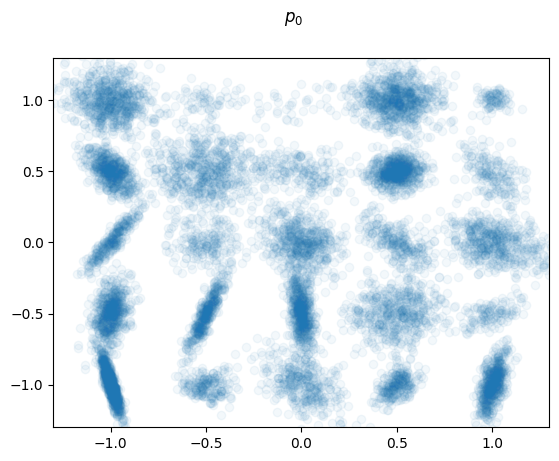

In [3]:
def get_random_unitary(n=20, dim=2):
    seeds = torch.randn((n, dim, dim))
    U, _, _ = torch.linalg.svd(seeds)
    S = torch.stack([torch.diag(s) for s in torch.rand((n, dim))])
    return U @ S @ U.mT

means = torch.stack(
    torch.meshgrid(
        torch.linspace(-1, 1, 5),
        torch.linspace(-1, 1, 5),
    )
).flatten(1, 2).T
covars = get_random_unitary(n=means.shape[0], dim=means.shape[1])*(0.15**2)
weights = torch.rand(means.shape[0])
weights = weights / weights.sum()
def make_noised_mixture(means, covars, weights, sigma):
    return torch.distributions.MixtureSameFamily(
        component_distribution=torch.distributions.MultivariateNormal(
            loc=means, covariance_matrix=covars + torch.eye(covars.shape[-1])[None]*sigma**2
        ),
        mixture_distribution=torch.distributions.Categorical(probs=weights)
    )

def denoiser_fn_mixture(x, sigma):
    score = torch.func.grad(lambda y: make_noised_mixture(means, covars, weights, sigma).log_prob(y).sum())(x)
    return x + (sigma**2) * score

fig, ax = plt.subplots(1, 1)
fig.suptitle(r"$p_{0}$")
ax.scatter(*make_noised_mixture(means, covars, weights, sigma=0).sample((10_000,)).T, alpha=.05)
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([-1.3, 1.3])
fig.show()

In [4]:
sigmas = torch.linspace(0.002**(1/3), 80**(1/3), 100)**3
ddpm_samples = ddpm(
    initial_samples = torch.randn((10_000, 2))*((sigmas[-1]**2 + 1)**.5),
    sigmas = sigmas,
    denoiser_fn=denoiser_fn_mixture
)
ode_samples = probability_flow_ode(
    initial_samples = torch.randn((10_000, 2))*((sigmas[-1]**2 + 1)**.5),
    sigmas = sigmas,
    denoiser_fn=denoiser_fn_mixture
)

99it [00:00, 137.25it/s]
99it [00:00, 130.79it/s]


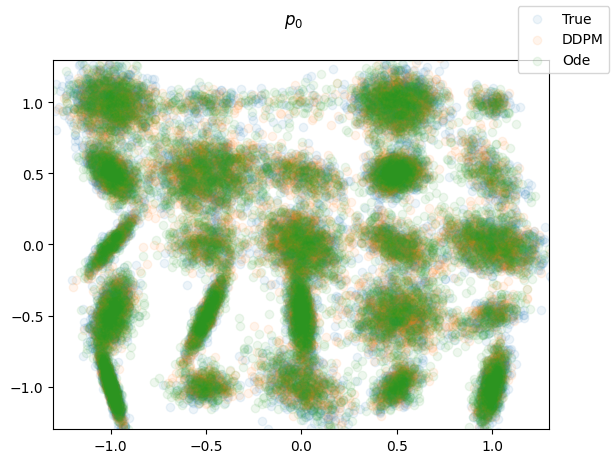

In [5]:
fig, ax = plt.subplots(1, 1)
fig.suptitle(r"$p_{0}$")
ax.scatter(*make_noised_mixture(means, covars, weights, sigma=0).sample((10_000,)).T, alpha=.08, label="True")
ax.scatter(*ddpm_samples.T, alpha=.08, label="DDPM")
ax.scatter(*ode_samples.T, alpha=.08, label="Ode")
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([-1.3, 1.3])
fig.legend()
fig.show()

In [6]:
from diffusers import UNet2DModel, DDPMScheduler

model_id = "google/ddpm-celebahq-256"
scheduler = DDPMScheduler.from_pretrained(model_id)
model = UNet2DModel.from_pretrained(model_id).to("cuda").eval().requires_grad_(False)


def denoiser_fn_hf(x, sigma):
    # This part belows convert the variance exploding framework to the variance preserving.

    eq_alpha = 1 / (sigma**2 + 1)
    get_closest = torch.abs(scheduler.alphas_cumprod - eq_alpha).argmin().item()
    closest_alpha = scheduler.alphas_cumprod[get_closest]
    eq_x = x / (sigma**2 + 1)**.5
    
    out_model = model(eq_x, get_closest).sample
    pred_x0 = ((eq_x  -  ((1 - closest_alpha)**.5)*out_model) / (closest_alpha**.5)).clip(-1, 1)
    return pred_x0

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
sigmas = ((1/scheduler.alphas_cumprod - 1)**.5)[::5]
ddpm_samples = ddpm(
    initial_samples = torch.randn((1, 3, 256, 256), device="cuda")*((sigmas[-1]**2 + 1)**.5),
    sigmas = sigmas,
    denoiser_fn=denoiser_fn_hf
)
ode_samples = probability_flow_ode(
    initial_samples = torch.randn((1, 3, 256, 256), device="cuda")*((sigmas[-1]**2 + 1)**.5),
    sigmas = sigmas,
    denoiser_fn=denoiser_fn_hf
)

0it [00:00, ?it/s]

199it [00:14, 13.85it/s]
34it [00:02, 14.18it/s]

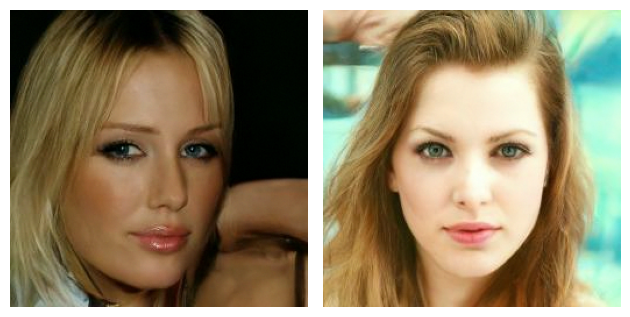

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow((data2img(ddpm_samples[0].clip(-1, 1))))
axes[1].imshow((data2img(ode_samples[0].clip(-1, 1))))
for ax in axes:
    ax.set_axis_off()
fig.tight_layout()
fig.show()

### Errors:
As we have seen in class, there are 3 main sources of error the generative procedure.

1. Initialization error: $$ \propto W_2(\operatorname{Law}(X_T), \mathcal{N}(0, (\sigma_T^2 + 1)Idm))\;.$$
2. Training error: $$ \propto \sum_{t=0}^{T}\mathbb{E}[\|D(X_t, \sigma_t) - X_0\|^2] \;.$$
3. discretization error: $$ \propto (1 - \frac{\sigma_t^2}{\sigma_{t+1}^2})\;.$$

Illustration of the discretization error.

In [ ]:
from ot import emd2, dist

def calculate_wasserstein_2(samples_1: torch.Tensor, samples_2: torch.Tensor) -> torch.Tensor:
    n1 = samples_1.shape[0]
    n2 = samples_2.shape[0]
    return emd2(torch.ones(n1)/n1, torch.ones(n2)/n2, dist(samples_1, samples_2, metric="euclidean"), log=False)


sigma_max = 40
data_std =  make_noised_mixture(means, covars, weights, sigma=0).sample((10_000,)).std().item()
dim = 2
n_rep = 10
rho = 1
n_steps_to_try = [10, 20, 50, 100, 250, 500, 1000]

w2_losses_n_steps = {"ddpm": [], "ode": []}
for n_steps in n_steps_to_try:
    sigmas = torch.linspace(0.002**(1/rho), sigma_max**(1/rho), n_steps)**rho
    for alg in w2_losses_n_steps.keys():
        w2_losses_n_steps[alg].append([])
        if alg == 'ddpm':
            sampler = partial(ddpm, sigmas=sigmas, denoiser_fn=denoiser_fn_mixture)
        elif alg == "ode":
            sampler = partial(sampler, sigmas=sigmas, denoiser_fn=denoiser_fn_mixture)
        else:
            raise NotImplementedError()


        for i in range(n_rep):
            w=calculate_wasserstein_2(
                sampler(
                initial_samples = torch.randn((10_000, dim))*sigma_max
                ),
                make_noised_mixture(means, covars, weights, sigma=0).sample((10_000,))
            ).item()
            w2_losses_n_steps[alg][-1].append(
                w
            )


9it [00:00, 152.04it/s]
/home/gvictorinocardoso/sgm_tps/.venv/lib/python3.12/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
9it [00:00, 135.10it/s]
9it [00:00, 143.07it/s]
9it [00:00, 126.44it/s]
9it [00:00, 137.45it/s]
9it [00:00, 137.97it/s]
9it [00:00, 150.69it/s]
9it [00:00, 144.17it/s]
9it [00:00, 157.98it/s]
9it [00:00, 156.10it/s]
9it [00:00, 158.24it/s]
9it [00:00, 159.69it/s]
9it [00:00, 140.89it/s]
9it [00:00, 140.92it/s]
9it [00:00, 122.74it/s]
9it [00:00, 136.28it/s]
9it [00:00, 159.15it/s]
9it [00:00, 160.00it/s]
9it [00:00, 139.03it/s]
9it [00:00, 134.19it/s]
19it [00:00, 146.51it/s]
19it [00:00, 150.23it/s]
19it [00:00, 162.46it/s]
19it [00:00, 143.83it/s]
19it [00:00, 143.04it/s]
19it [00:00, 163.28it/s]
19it [00:00, 142.11it/s]
19it [00:00, 129.37it/s]
19it [00:00, 145.36it/s]
19it [00:00, 141.94it/s]
19it [00:00, 147.32it/s]
19it [00:00, 134.36it/s]
19it [00:00, 145.24it/s

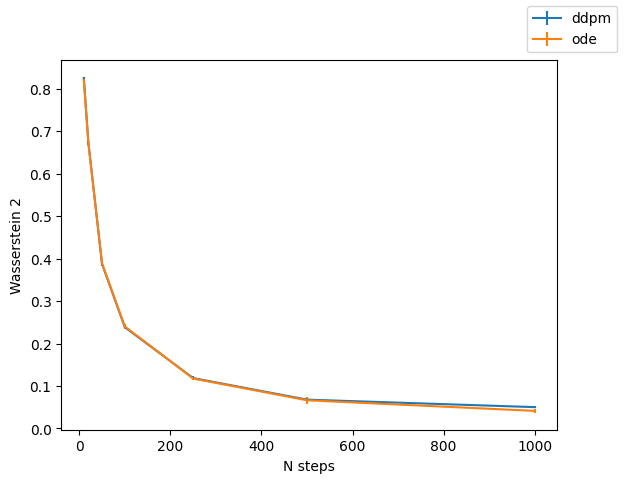

In [ ]:
fig, ax = plt.subplots(1, 1)
for alg, stats_per_alg in w2_losses_n_steps.items():
    ax.errorbar(n_steps_to_try, [np.mean(w) for w in stats_per_alg], [np.std(w) for w in stats_per_alg], label=alg)
ax.set_ylabel("Wasserstein 2")
ax.set_xlabel(r"N steps")
fig.legend()
fig.show()


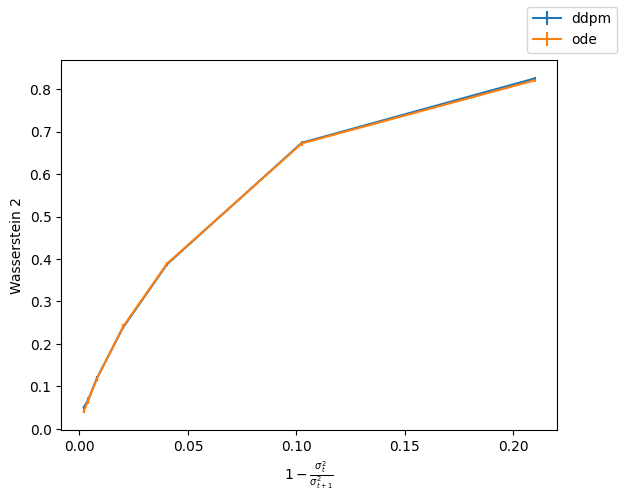

In [ ]:
def calc_min_step(sigmas):
    return torch.min((1 - sigmas[:-1]**2/sigmas[1:]**2))
fig, ax = plt.subplots(1, 1)
for alg, stats_per_alg in w2_losses_n_steps.items():
    ax.errorbar([calc_min_step(torch.linspace(0.002**(1/rho), sigma_max**(1/rho), n_steps)**rho) for n_steps in n_steps_to_try], [np.mean(w) for w in stats_per_alg], [np.std(w) for w in stats_per_alg], label=alg)
ax.set_ylabel("Wasserstein 2")
ax.set_xlabel(r"$1 - \frac{\sigma_t^2}{\sigma_{t+1}^2}$")
fig.legend()
fig.show()


## Stable diffusion

We now apply the generative samplers above to stable diffusion. This is an adaptation of https://huggingface.co/blog/stable_diffusion

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(1000)
all_sigmas = torch.flip(scheduler.sigmas, dims=(0,))
sigma_max = 14.6146

def create_denoiser_hf(text):
    text_input = tokenizer(text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    def denoiser_hf(x, sigma, t):
        with torch.no_grad():
            pred_x0 = x - unet(x / ((sigma**2 + 1)**.5), t, encoder_hidden_states=text_embeddings).sample * sigma
        return pred_x0
    return denoiser_hf

In [ ]:
def decode_image(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    return (image / 2 + 0.5).clamp(0, 1)

In [ ]:
batch_size=1
height=512
width=512
generator = torch.manual_seed(0) 
samples = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator
)*sigma_max
samples = samples.to(device)

/tmp/ipykernel_932967/4262423904.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [ ]:

denoiser_fn = create_denoiser_hf("A photograph of an astronaut riding a horse.")

scheduler.set_timesteps(100)
sigmas = torch.flip(scheduler.sigmas, dims=(0,))

derivatives = []
order = 4
for t in tqdm(scheduler.timesteps):
    # Getting sigma from timesteps
    step_index = (scheduler.timesteps == t).nonzero().item()
    sigma = scheduler.sigmas[step_index]

    pred_x0 = denoiser_fn(samples, sigma, t)

    #Calculating 4th order approximation of ODE...
    derivative = ((samples - pred_x0) / sigma).clone()
    derivatives.append(derivative)
    if len(derivatives) > order:
        derivatives.pop(0)

    # 3. Compute linear multistep coefficients
    order = min(step_index + 1, order)
    lms_coeffs = [scheduler.get_lms_coefficient(order, step_index, curr_order) for curr_order in range(order)]

    # 4. Compute previous sample based on the derivatives path
    samples = samples + sum(
        coeff * derivative for coeff, derivative in zip(lms_coeffs, reversed(derivatives))
    )

100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


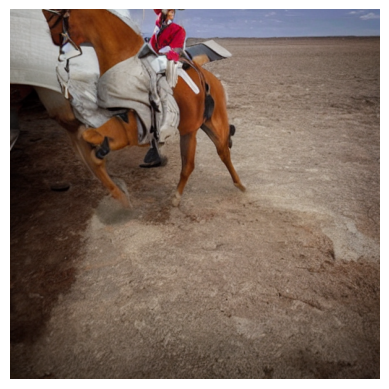

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.imshow(decode_image(samples)[0].permute(1,2,0).float().cpu())
ax.set_axis_off()
fig.show()